# Check which elements have the best constraining power by examining the slope of the chemical gradient with Jz in a bin of R around the Sun

In [1]:
import copy
import os

from astropy.constants import G
import astropy.table as at
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
from astropy.io import fits
from astropy.stats import bootstrap
import tqdm
# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
import gala.integrate as gi
from gala.units import galactic

import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline

from torusimaging import LabelOrbitModel
# from empaf import DensityOrbitModel
from torusimaging.plot import plot_data_models_residual
from torusimaging.model_helpers import generalized_logistic_func_alt

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import nmmn.plots
import vorbin
wolfram=nmmn.plots.wolframcmap() # for Mathematica's cmap
parula=nmmn.plots.parulacmap() # for MATLAB's cmap
turbo=nmmn.plots.turbocmap() # Turbo
import warnings
warnings.filterwarnings('ignore')

import utils


In [2]:
# LOAD THE DATA
# this is the latest APOGEE catalogue that APW sent me with orbital properties determined using StarHorse distances

path = '/Users/dhortadarrington/Documents/Master/data/allstar-dr17-StarHorse-Gaiadr3'
tb = fits.open(path)
data = tb[1].data 

# load in the mask for the lowalpha disc
lowa = np.load('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/sav/lowa_mask.npy',allow_pickle=True)
print(len(data[lowa]))

172656


In [3]:
# define cnfe in case we want it
cnfe = np.log10(10**(data['C_FE']+data['FE_H']+8.39) + 10**(data['N_FE']+data['FE_H']+7.78)) - np.log10(10.**8.39 + 10.**7.78) - data['FE_H']


In [4]:
# find the Suns Rg
x_sun, y_sun, z_sun = np.array([-8.275, 0, 0.0208])
vx_sun, vy_sun, vz_sun = np.array([12.9, 245.6, 7.78])
Lz_sun = x_sun*vy_sun
Rg_sun = np.abs(Lz_sun)/229.

print(Rg_sun)

8.874847161572053


In [5]:
import astropy.units as u
x = data['xyz'][:,0]
y = data['xyz'][:,1]
z = data['xyz'][:,2]
vx = data['vxyz'][:,0]
vy = data['vxyz'][:,1]
vz = data['vxyz'][:,2]
vz = (vz*u.km/u.s)
vz = vz.to(u.kpc/u.Gyr)
x = x*u.kpc
y = y*u.kpc
z = z*u.kpc

# Eilers rotation curve
Rgal = np.sqrt(data['xyz'][:,0]**2+data['xyz'][:,1]**2)
vcirc = 229.-1.7*(Rgal-8.275)
Rg = -(data['L'][:,2]/vcirc)
deltaR = Rgal-Rg
phi = np.arctan(data['xyz'][:,1]/data['xyz'][:,0])

#transform to cylindrical velocities
vr = +data['vxyz'][:,0]*np.cos(phi)+data['vxyz'][:,1]*np.sin(phi)
vt = -data['vxyz'][:,0]*np.sin(phi)+data['vxyz'][:,1]*np.cos(phi)


# so that we can apply OTI, we need to have some good approximation to circular orbits that are decomposable in R and z
# omask = (np.fabs(z)<2*u.kpc)&(np.fabs(vz)<80*u.kpc/u.Gyr)&(np.fabs(deltaR)<3)
omask = (np.abs(z)<2*u.kpc)&(np.abs(vz)<80*u.kpc/u.Gyr)&(np.abs(deltaR)<1)&(np.abs(vr)<50)
# &(data['ecc']<0.2)
lowa_omask = lowa&omask
# lowa_omask2 = lowa&omask2

print('There are '+str(len(data[lowa]))+' stars in the parent sample')
print('There are '+str(len(data[lowa_omask]))+' stars in the sample we model')


There are 172656 stars in the parent sample
There are 94685 stars in the sample we model


In [6]:
delta = 0.5
rgbin = (Rg>(Rg_sun-delta))&(Rg<(Rg_sun+delta))&omask&lowa&(data['AL_FE']>-10)&(data['MN_FE']>-10)&(data['NI_FE']>-10)


In [7]:
mask_vz = np.abs(data['vxyz'][:,2])<10

# Plot z vs abun to see which abundances have the largest scatter

In [8]:
xfe=np.dstack([data['FE_H'],cnfe,data['O_FE'],data['MG_FE'],data['AL_FE'],data['SI_FE'],data['CA_FE'],data['MN_FE'],data['NI_FE']])[0].T
xfe_labels = ['[Fe/H]','[(C+N)/Fe]','[O/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[Ca/Fe]','[Mn/Fe]','[Ni/Fe]']
vmins = [-0.3,-0.02,-0.02,0.0,-0.04,0.0,-0.04,-0.04,-0.01]
vmaxs = [0.15,0.06,0.12,0.12,0.12,0.06,0.06,0.07,0.05]


In [9]:
def running_mean(xs, ys):
    grid = np.linspace(np.min(xs),np.max(xs),80)
    delta = grid[1]-grid[0]
    vals = np.zeros((len(grid)))
    
    for indx, i in enumerate(grid):
        mask = (xs<(i+delta))&(xs>i)
        vals[indx] = np.mean(ys[mask])
    return vals,grid
    

In [10]:
def running_median(xs, ys):
    grid = np.linspace(np.min(xs),np.max(xs),80)
    delta = grid[1]-grid[0]
    vals = np.zeros((len(grid)))
    
    for indx, i in enumerate(grid):
        mask = (xs<(i+delta))&(xs>i)
        vals[indx] = np.median(ys[mask])
    return vals,grid

In [11]:
def running_std(xs, ys):
    grid = np.linspace(np.min(xs),np.max(xs),80)
    delta = grid[1]-grid[0]
    vals = np.zeros((len(grid)))
    
    for indx, i in enumerate(grid):
        mask = (xs<(i+delta))&(xs>i)
        vals[indx] = np.std(ys[mask])
    return vals,grid

In [12]:
from scipy import stats
from matplotlib.colors import LogNorm

Text(0.5, 0, '$z$ [kpc]')

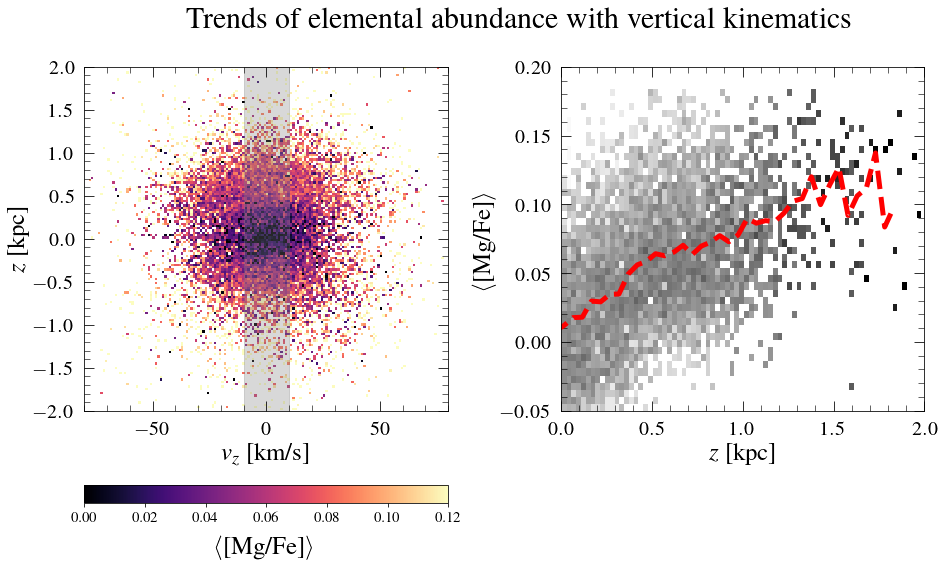

In [16]:
fig = plt.figure(figsize=(13,7),constrained_layout=True,facecolor='white')
nbins=151
abun = data['MG_FE']

fig.suptitle('Trends of elemental abundance with vertical kinematics',fontsize=30,x=0.55,y=1.1)


plt.subplot(1,2,1)
# plt.title(r'Element abundance gradients in vertical kinematics',fontsize=22,pad=20)
binx = np.linspace(np.min(data['vxyz'][:,2][lowa_omask&(abun>-10)&rgbin]),np.max(data['vxyz'][:,2][lowa_omask&(abun>-10)&rgbin]),nbins)
biny = np.linspace(np.min(data['xyz'][:,2][lowa_omask&(abun>-10)&rgbin]),np.max(data['xyz'][:,2][lowa_omask&(abun>-10)&rgbin]),nbins)    
hist = stats.binned_statistic_2d(data['vxyz'][:,2][lowa_omask&(abun>-10)&rgbin],data['xyz'][:,2][lowa_omask&(abun>-10)&rgbin], abun[lowa_omask&(abun>-10)&rgbin], statistic='mean', bins=[binx,biny])
plot_x, plot_y = np.meshgrid(binx,biny) 
color = plt.pcolormesh(plot_x, plot_y, hist[0].T, cmap='magma',vmin=0.,vmax=0.12)
plt.axvspan(-10,10,alpha=0.3,color='gray')
plt.xlim(-80,80)
plt.ylim(-2,2)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlabel(r'$v_z$ [km/s]', fontsize=25)
plt.ylabel(r'$z$ [kpc]', fontsize=25)


cbar = fig.colorbar(color,  aspect=20,orientation='horizontal',location='bottom')
cbar.set_label(label=r'$\langle$[Mg/Fe]$\rangle$',fontsize=25,labelpad=10)
cbar.ax.tick_params(labelsize=15,pad=5)
cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.xaxis.set_label_position('bottom')

plt.subplot(1,2,2)
# plt.title(r'Linear relationship between [Mg/Fe] and vertical height',fontsize=22,pad=20)
binx = np.linspace(np.min(data['xyz'][:,2][rgbin&mask_vz&(abun>-10)]),np.max(data['xyz'][:,2][rgbin&mask_vz&(abun>-10)]),nbins)
biny = np.linspace(np.min(abun[rgbin&mask_vz&(abun>-10)]),np.max(abun[rgbin&mask_vz&(abun>-10)]),nbins)    
hist, xedges, yedges = np.histogram2d(data['xyz'][:,2][rgbin&mask_vz&(abun>-10)],abun[rgbin&mask_vz&(abun>-10)], bins=151)
hist = hist.T
#     hist *=  (hist - hist.min(axis=0))/ (hist.max(axis=0)-hist.min(axis=0))
hist = hist / hist.sum(axis=0)[None]

means,zs = running_mean(data['xyz'][:,2][rgbin&mask_vz&(abun>-10)],abun[rgbin&mask_vz&(abun>-10)])

plt.pcolormesh(xedges, yedges, hist, cmap='binary',norm=LogNorm())
plt.plot(zs,means,c='r',lw=5,ls='dashed')
plt.xlim(0,2)
plt.ylim(-0.05,0.2)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.ylabel(r'$\langle$[Mg/Fe]$\rangle$', fontsize=25)
plt.xlabel(r'$z$ [kpc]', fontsize=25)

# plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/plots_paper/gradients-app.pdf',dpi=600,fmt='pdf', bbox_inches = 'tight',rasterized=True)



In [13]:
xfe=np.dstack([data['O_FE'],data['MG_FE'],data['AL_FE'],data['SI_FE'],data['FE_H'],data['NI_FE']])[0].T

xfe_labels = ['[O/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[Fe/H]','[Ni/Fe]']
vmins = [-0.05,0.,0.,0.,-0.3,-0.03]
vmaxs = [0.1,0.1,0.1,0.1,0.3,0.06]


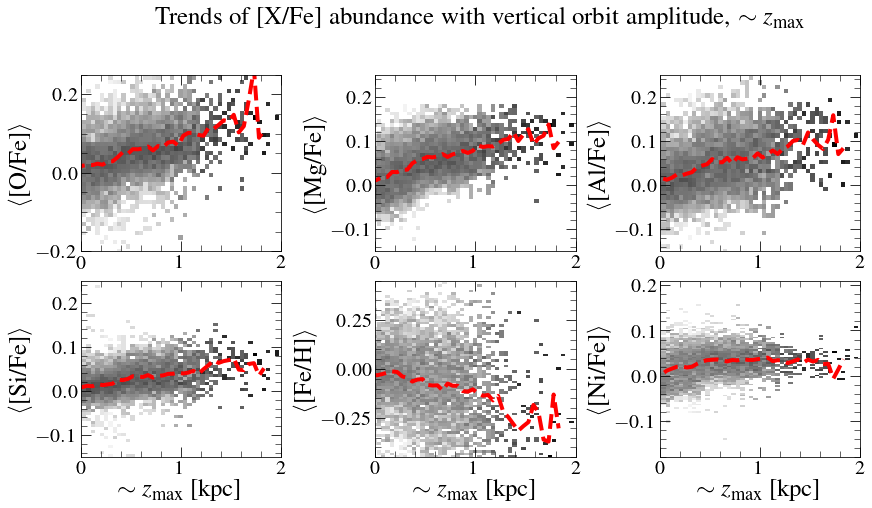

In [14]:
from scipy import stats
from matplotlib.colors import LogNorm

nbins=51
stat='mean'
fig = plt.figure(figsize=(12,6),constrained_layout=True,facecolor='white')
fig.suptitle('Trends of [X/Fe] abundance with vertical orbit amplitude, $\sim z_{\mathrm{max}}$',fontsize=25,x=0.55,y=1.15)

all_axes = []

for indx, i in enumerate(xfe):
    
    all_ax = plt.subplot(2,3,indx+1)
    all_axes.append(all_ax)

    abun = i
    norm = 1
    binx = np.linspace(np.min(data['xyz'][:,2][rgbin&mask_vz&(np.abs(abun)<3)]),np.max(data['xyz'][:,2][rgbin&mask_vz&(np.abs(abun)<3)]),nbins)
    biny = np.linspace(np.min(i[rgbin&mask_vz&(np.abs(abun)<3)]),np.max(i[rgbin&mask_vz&(np.abs(abun)<3)]),nbins)    
    hist, xedges, yedges = np.histogram2d(data['xyz'][:,2][rgbin&mask_vz&(np.abs(abun)<3)],i[rgbin&mask_vz&(np.abs(abun)<3)], bins=91)
    hist = hist.T
#     hist *=  (hist - hist.min(axis=0))/ (hist.max(axis=0)-hist.min(axis=0))
    hist = hist / hist.sum(axis=0)[None]
    
    means,zs = running_mean(data['xyz'][:,2][rgbin&mask_vz&(abun>-10)],i[rgbin&mask_vz&(abun>-10)])
    
    plt.pcolormesh(xedges, yedges, hist, cmap='binary',norm=LogNorm(),rasterized=True)
    plt.plot(zs,means,c='r',lw=4,ls='dashed')
    plt.xlim(0,2)
#     plt.ylim(-0.1,0.2)
    plt.ylim(vmins[indx]-0.15,vmaxs[indx]+0.15)
    plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()
    plt.ylabel(r'$\langle$'+str(xfe_labels[indx])+r'$\rangle$', fontsize=25)


all_axes = np.reshape(all_axes,(2,3))
for ax in all_axes[-1,:]:
    ax.set_xlabel('$\sim z_{\mathrm{max}}$ [kpc]', fontsize=25,labelpad=0.1)
    
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/plots_paper/zmax_xfe-colnorm-paper.pdf',dpi=250, bbox_inches = 'tight')


In [36]:
xfe=np.dstack([data['C_FE'],data['N_FE'],data['O_FE'],data['NA_FE'],data['MG_FE'],data['AL_FE'],data['SI_FE'],\
               data['S_FE'],data['K_FE'],data['CA_FE'],data['TI_FE'],data['V_FE'],data['CR_FE'],\
               data['MN_FE'],data['FE_H'],data['CO_FE'],data['NI_FE'],data['CE_FE']])[0].T

xfe_labels = ['[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]',\
             '[S/Fe]','[K/Fe]','[Ca/Fe]','[Ti/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]',\
             '[Ni/Fe]','[Ce/Fe]']
vmins = [-0.1,0.1,0.,-0.05,0.,0.,-0.02,0.,0.,-0.05,-0.05,-0.15,-0.03,-0.03,-0.3,-0.03,-0.03,-0.4]
vmaxs = [0.05,0.3,0.1,0.075,0.1,0.1,0.1,0.1,0.1,0.08,0.08,0.05,0.04,0.04,0.3,0.1,0.06,0.05]


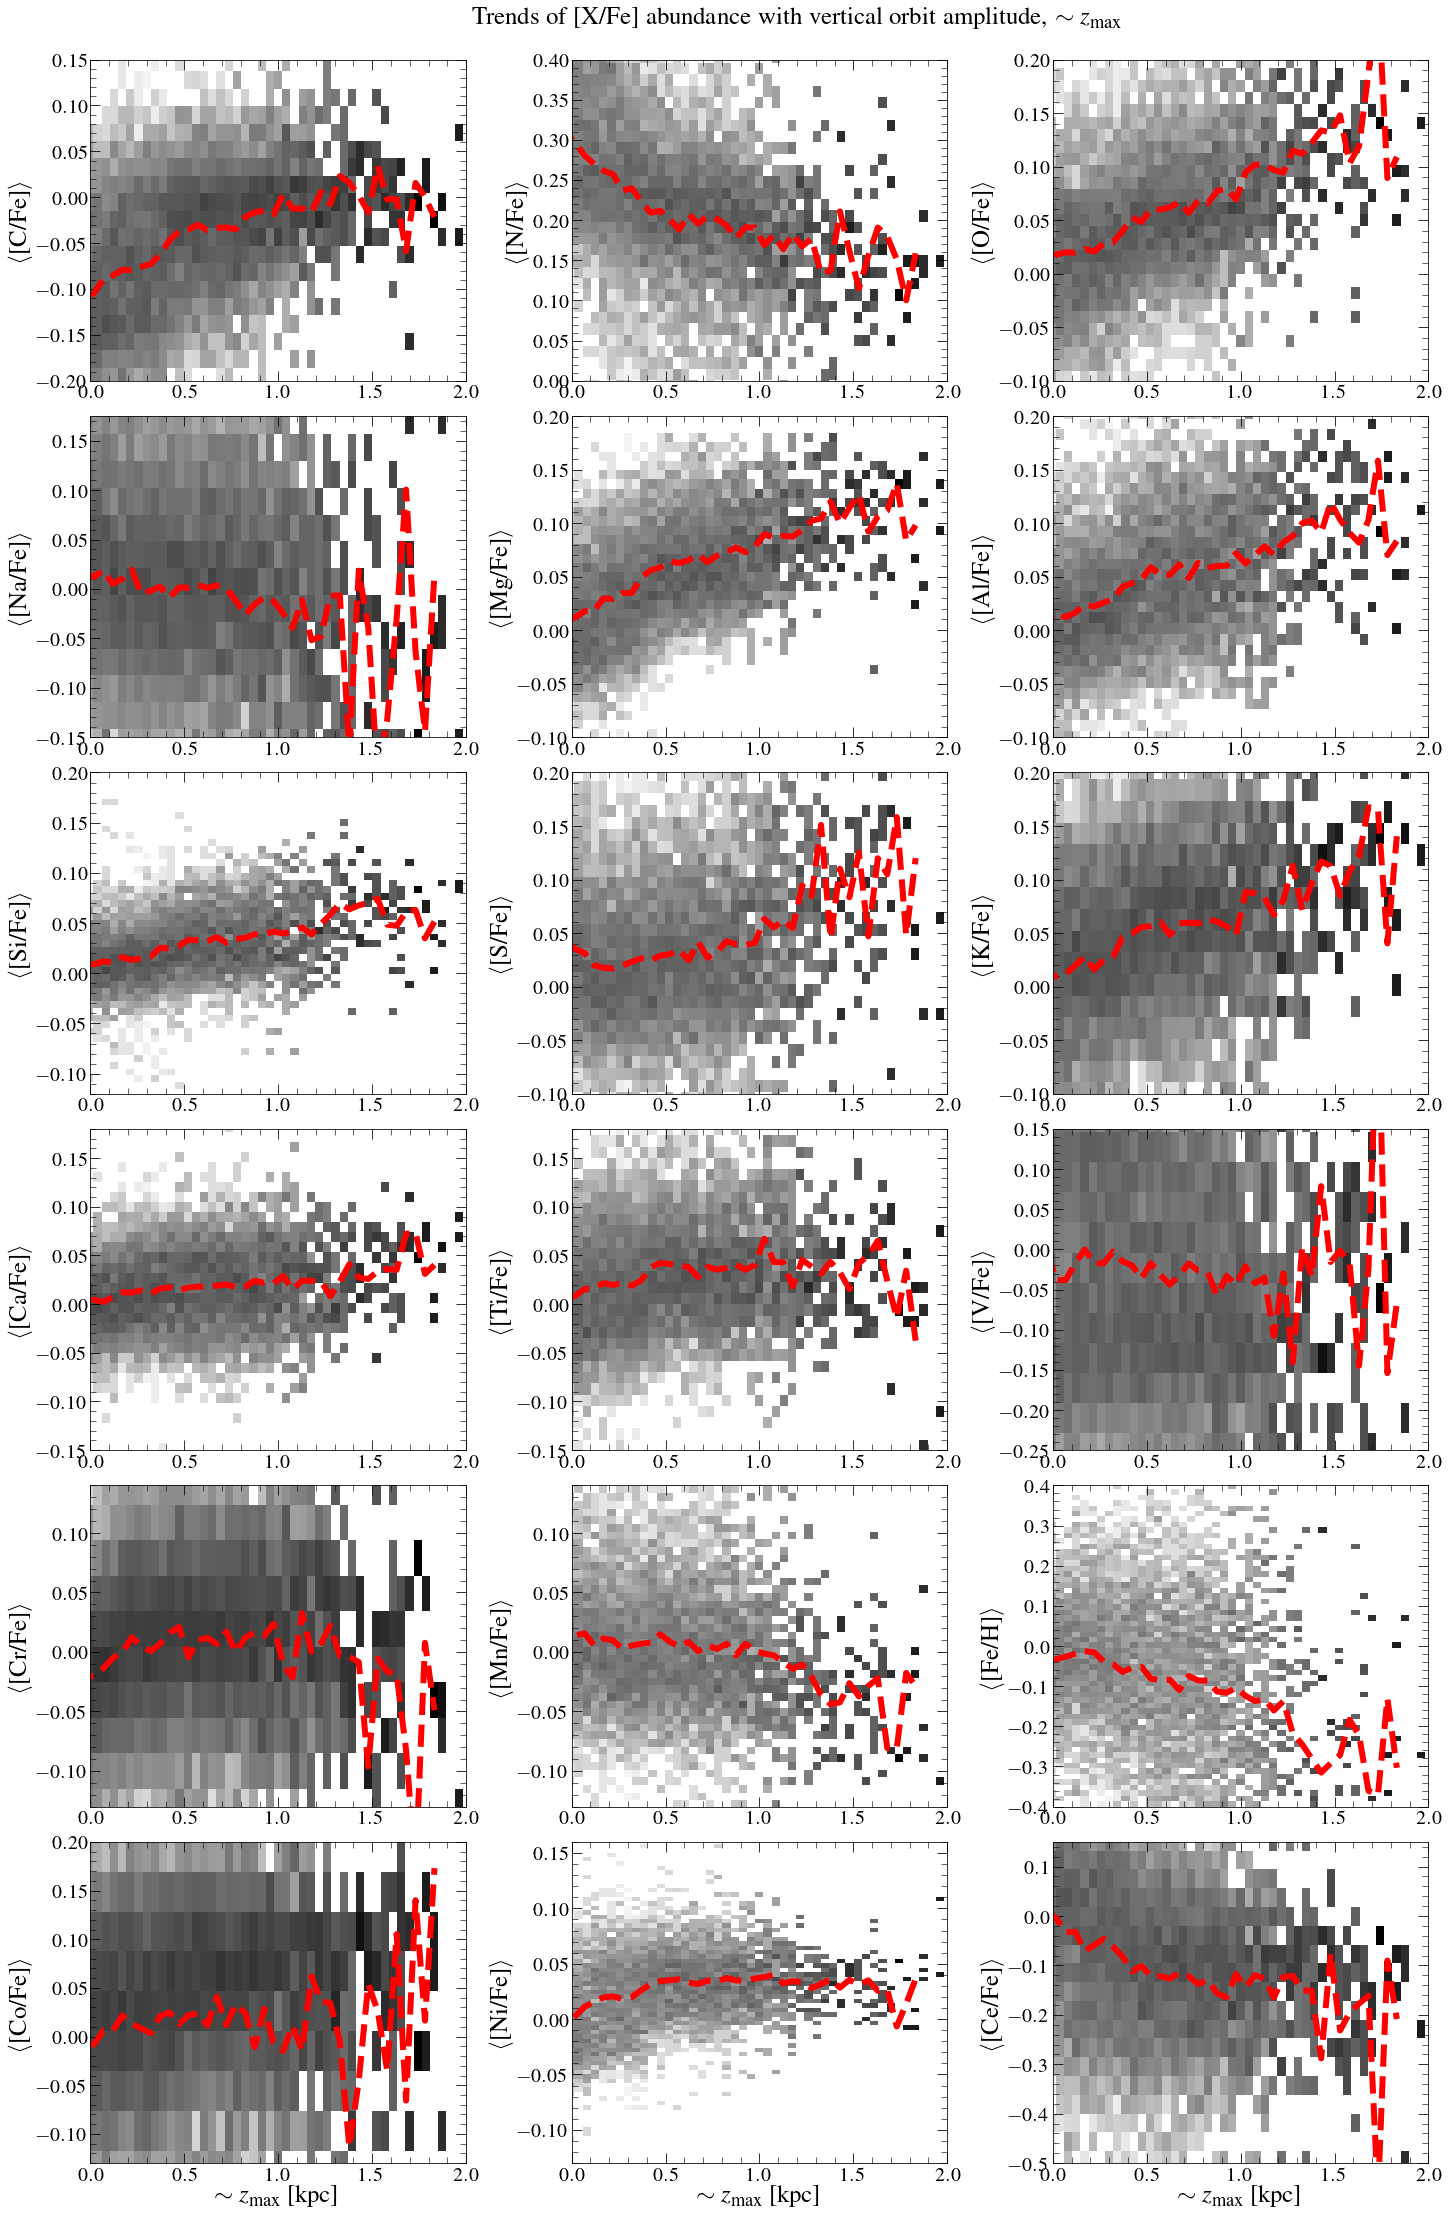

In [37]:
from scipy import stats
from matplotlib.colors import LogNorm

nbins=51
stat='mean'
fig = plt.figure(figsize=(20,30),constrained_layout=True,facecolor='white',rasterized=True)
fig.suptitle('Trends of [X/Fe] abundance with vertical orbit amplitude, $\sim z_{\mathrm{max}}$',fontsize=25,x=0.55,y=1.02)

all_axes = []

for indx, i in enumerate(xfe):
    
    all_ax = plt.subplot(6,3,indx+1)
    all_axes.append(all_ax)

    abun = i
    norm = 1
    binx = np.linspace(np.min(data['xyz'][:,2][rgbin&mask_vz&(np.abs(abun)<3)]),np.max(data['xyz'][:,2][rgbin&mask_vz&(np.abs(abun)<3)]),nbins)
    biny = np.linspace(np.min(i[rgbin&mask_vz&(np.abs(abun)<3)]),np.max(i[rgbin&mask_vz&(np.abs(abun)<3)]),nbins)    
    hist, xedges, yedges = np.histogram2d(data['xyz'][:,2][rgbin&mask_vz&(np.abs(abun)<3)],i[rgbin&mask_vz&(np.abs(abun)<3)], bins=91)
    hist = hist.T
#     hist *=  (hist - hist.min(axis=0))/ (hist.max(axis=0)-hist.min(axis=0))
    hist = hist / hist.sum(axis=0)[None]
    
    means,zs = running_mean(data['xyz'][:,2][rgbin&mask_vz&(abun>-10)],i[rgbin&mask_vz&(abun>-10)])
    
    plt.pcolormesh(xedges, yedges, hist, cmap='binary',norm=LogNorm())
    plt.plot(zs,means,c='r',lw=6,ls='dashed')
    plt.xlim(0,2)
    plt.ylim(vmins[indx]-0.1,vmaxs[indx]+0.1)
    plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()
    plt.ylabel(r'$\langle$'+str(xfe_labels[indx])+r'$\rangle$', fontsize=25)


all_axes = np.reshape(all_axes,(6,3))
for ax in all_axes[-1,:]:
    ax.set_xlabel('$\sim z_{\mathrm{max}}$ [kpc]', fontsize=25,labelpad=0.1)
    
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/plots_paper/zmax_xfe-colnorm.pdf',dpi=300, bbox_inches = 'tight')


# For all elements, calculate the slope over the average scatter squared to get an idea of the signal to noise

In [21]:
xfe=np.dstack([data['C_FE'],data['N_FE'],cnfe,data['O_FE'],data['NA_FE'],data['MG_FE'],data['AL_FE'],data['SI_FE'],\
               data['S_FE'],data['K_FE'],data['CA_FE'],data['TI_FE'],data['V_FE'],data['CR_FE'],\
               data['MN_FE'],data['FE_H'],data['CO_FE'],data['NI_FE'],data['CE_FE']])[0].T

xfe_labels = ['[C/Fe]','[N/Fe]','[(C+N)/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]',\
             '[S/Fe]','[K/Fe]','[Ca/Fe]','[Ti/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]',\
             '[Ni/Fe]','[Ce/Fe]']
vmins = [-0.1,0.1,-0.03,0.,-0.05,0.,0.,-0.02,0.,0.,-0.05,-0.05,-0.15,-0.03,-0.03,-0.3,-0.03,-0.03,-0.4]
vmaxs = [0.05,0.3,0.06,0.1,0.075,0.1,0.1,0.1,0.1,0.1,0.08,0.08,0.05,0.04,0.04,0.3,0.1,0.06,0.05]


In [22]:
medians = np.zeros((len(xfe),80))
stds = np.zeros((len(xfe),80))

for indx, i in enumerate(xfe):
    abun = i
    medians[indx],zs = running_median(data['xyz'][:,2][rgbin&mask_vz&(abun>-10)&(data['xyz'][:,2]>0)],i[rgbin&mask_vz&(abun>-10)&(data['xyz'][:,2]>0)])
    stds[indx],zs = running_std(data['xyz'][:,2][rgbin&mask_vz&(abun>-10)&(data['xyz'][:,2]>0)],i[rgbin&mask_vz&(abun>-10)&(data['xyz'][:,2]>0)])


In [23]:
from scipy.optimize import curve_fit

In [24]:
def linear(xs,m,b):
    return xs*m+b

In [25]:
slopes = np.zeros((len(xfe),2))

for indx, i in enumerate(xfe):
    abun = i
    mask_height = (data['xyz'][:,2]>0)&(data['xyz'][:,2]>0)

    slopes[indx], pcov = curve_fit(linear, data['xyz'][:,2][rgbin&mask_vz&(abun>-10)&mask_height],\
                                  i[rgbin&mask_vz&(abun>-10)&mask_height])

In [26]:
mean_std = np.nanmean(stds,axis=1)
median_std = np.nanmedian(stds,axis=1)

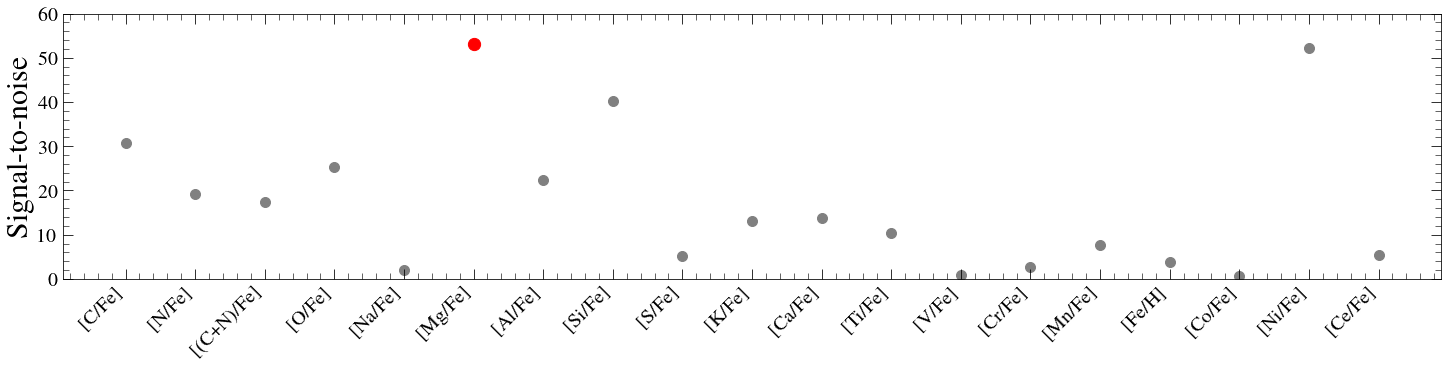

In [30]:
fig = plt.figure(figsize=(20,5),constrained_layout=True,facecolor='white',rasterized=True)
# fig.suptitle('Trends of [X/Fe] abundance with vertical orbit amplitude, $z_{\mathrm{max}}$',fontsize=25,x=0.55,y=1.1)

plt.scatter(xfe_labels,np.abs(slopes[:,0])/mean_std**2,s=100,c='gray')
plt.scatter(5,np.abs(slopes[5,0])/mean_std[5]**2,s=150,c='r')
# plt.scatter(xfe_labels,ranges/np.abs(stds_median),s=200,c=colores)
# plt.arrow(x=5,y=11,dx=0,dy=6,color='gray',head_width=0.2,head_length=1)
# plt.text(4.75,18.5,str(round(ranges[-1]/np.abs(stds_median[-1]),2)),fontsize=18)
# plt.yscale('log')
plt.ylim(0,60)
plt.ylabel(r'Signal-to-noise',fontsize=30)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6,pad=5)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xticks(rotation=45, ha='right')

plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/plots_paper/snr.pdf',dpi=300, bbox_inches = 'tight')


In [31]:
np.abs(slopes[:,0])/mean_std**2

array([30.7640165 , 19.15096655, 17.48085517, 25.31727718,  1.91036206,
       53.1232599 , 22.25153382, 40.23821114,  5.22019532, 13.07720739,
       13.76366913, 10.35380147,  0.79741073,  2.74155305,  7.77415618,
        3.75035844,  0.63432618, 52.26515292,  5.36591806])

In [ ]:
medians = np.zeros((len(xfe),80))
stds = np.zeros((len(xfe),80))

for indx, i in enumerate(xfe):
    abun = i
    medians[indx],zs = running_median(data['xyz'][:,2][rgbin&mask_vz&(abun>-10)],i[rgbin&mask_vz&(abun>-10)])
    stds[indx],zs = running_std(data['xyz'][:,2][rgbin&mask_vz&(abun>-10)],i[rgbin&mask_vz&(abun>-10)])


In [ ]:
# plt.scatter(xfe_labels,np.mean(medians)/np.mean(stds))

In [ ]:
ranges = np.zeros((len(xfe)))

for indx, i in enumerate(xfe):
    abun = i
    percen = np.nanpercentile(abun,[1,50,99])
    ranges[indx] = percen[2]-percen[0]

In [ ]:
stds_median = np.nanmedian(stds,axis=1)


In [ ]:
colores = ['red','gray','gray','gray','gray','gray',]

In [ ]:
fig = plt.figure(figsize=(7,5),constrained_layout=True,facecolor='white')
# fig.suptitle('Trends of [X/Fe] abundance with vertical orbit amplitude, $z_{\mathrm{max}}$',fontsize=25,x=0.55,y=1.1)

plt.scatter(np.linspace(0,5,6),ranges/np.abs(stds_median),s=1)
plt.scatter(xfe_labels,ranges/np.abs(stds_median),s=200,c=colores)
plt.arrow(x=5,y=11,dx=0,dy=6,color='gray',head_width=0.2,head_length=1)
plt.text(4.75,18.5,str(round(ranges[-1]/np.abs(stds_median[-1]),2)),fontsize=18)
# plt.yscale('log')
plt.ylim(2,20)
# plt.xlabel(xfe_labels,labelpad=10)
plt.ylabel(r'[min$_{\mathrm{[X/Fe]}}$,max$_{\mathrm{[X/Fe]}}$]/$\sigma_{\mathrm{[X/Fe]}}$',fontsize=25)
plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6,pad=5)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/plots_paper/rangeoverscatter.pdf',dpi=300,fmt='pdf', bbox_inches = 'tight',rasterized=True)



In [ ]:
xfe=np.dstack([data['FE_H'],data['O_FE'],data['MG_FE'],data['AL_FE'],data['SI_FE'],data['MN_FE']])[0].T


In [ ]:
means,zs = running_mean(data['xyz'][:,2][rgbin&mask_vz&(data['MG_FE']>-10)],data['MG_FE'][rgbin&mask_vz&(data['MG_FE']>-10)])


In [ ]:
def linear(xs,m,b):
    return xs*m+b

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
popt, pcov = curve_fit(linear, zs[:-1], means[:-1])
print(popt)

In [ ]:
mask_z = np.abs(data['xyz'][:,2])<0.1

In [ ]:
xfe=np.dstack([data['FE_H'],cnfe,data['O_FE'],data['MG_FE'],data['AL_FE'],data['SI_FE'],data['CA_FE'],data['TI_FE'],data['MN_FE'],data['NI_FE']])[0].T
xfe_labels = ['[Fe/H]','[(C+N)/Fe]','[O/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[Ca/Fe]','[Ti/Fe]','[Mn/Fe]','[Ni/Fe]']
vmins = [-0.3,-0.02,-0.02,0.0,-0.04,0.0,-0.04,-0.04,-0.04,-0.01]
vmaxs = [0.15,0.06,0.12,0.12,0.12,0.06,0.06,0.07,0.07,0.05]

In [ ]:
from scipy import stats
from matplotlib.colors import LogNorm

nbins=51
stat='mean'
fig = plt.figure(figsize=(16,5),constrained_layout=True,facecolor='white')

all_axes = []

for indx, i in enumerate(xfe):
    
    all_ax = plt.subplot(2,5,indx+1)
    all_axes.append(all_ax)

    abun = i
    norm = 1
    binx = np.linspace(np.min(np.abs(data['vxyz'][:,2])[rgbin&mask_z&(abun>-10)]),np.max(np.abs(data['vxyz'][:,2])[rgbin&mask_z&(abun>-10)]),nbins)
    biny = np.linspace(np.min(i[rgbin&mask_z&(abun>-10)]),np.max(i[rgbin&mask_z&(abun>-10)]),nbins)    
    hist, xedges, yedges = np.histogram2d(np.abs(data['vxyz'][:,2])[rgbin&mask_z&(abun>-10)],i[rgbin&mask_z&(abun>-10)], bins=91)
    hist = hist.T
    hist *=  (hist - hist.min(axis=0))/ (hist.max(axis=0)-hist.min(axis=0))
    
    
    means,zs = running_mean(np.abs(data['vxyz'][:,2])[rgbin&mask_z&(abun>-10)],i[rgbin&mask_z&(abun>-10)])
    
    plt.pcolormesh(xedges, yedges, hist, cmap='binary')
    plt.plot(zs,means,c='r',lw=2,ls='dashed')
    plt.ylim(vmins[indx]-0.1,vmaxs[indx]+0.1)
    plt.tick_params(labelsize=22,direction='in',top=True,right=True,length=6)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()
    plt.ylabel(r'$\langle$'+str(xfe_labels[indx])+r'$\rangle$', fontsize=25)


all_axes = np.reshape(all_axes,(2,5))
for ax in all_axes[1,:]:
    ax.set_xlabel('$\sim |v_{z_{\mathrm{max}}}|$ [km/s]', fontsize=25,labelpad=0.1)
    
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/plots_paper/zmax_xfe_all.pdf',dpi=300,fmt='pdf', bbox_inches = 'tight',rasterized=True)
